In [ ]:
#%reset

In [ ]:
#install necessary packages
!pip install tabpfn tensorflow autokeras pandas numpy seaborn imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd           #for handling data in tabular form
import numpy as np            #for numerical operations
import tensorflow as tf       #for building and training deep learning models
import matplotlib.pyplot as plt   #for data visualization
import seaborn as sns         #for enhanced data visualization
import time                   #for tracking time
from sklearn.model_selection import train_test_split    #for splitting data into training and testing sets
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix #for evaluating model performance
from sklearn.preprocessing import OrdinalEncoder        #for encoding categorical variables
from tensorflow.keras.callbacks import EarlyStopping     #for early stopping during model training
from autokeras import StructuredDataClassifier   #autoKeras structured data classifier
from tabpfn import TabPFNClassifier   #custom classifier from tabpfn library

Using TensorFlow backend


In [ ]:
#mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset.csv')
df.head()

,Gene.symbol,P.Value,logFC,Cell Line
0,EDIL3,2.350000e-18,-6.356883,BAS
1,IGFBP7,2.230000e-19,-6.302001,BAS
2,TFPI,3.480000e-17,-5.950269,BAS
3,CLDN1,4.550000e-19,-5.599057,BAS
4,ANKRD1,2.650000e-18,-5.415740,BAS


In [ ]:
#get dimensions of dataframe
df.shape

(21312, 4)

In [ ]:
#drop missing values
df.dropna()

,Gene.symbol,P.Value,logFC,Cell Line
0,EDIL3,2.350000e-18,-6.356883,BAS
1,IGFBP7,2.230000e-19,-6.302001,BAS
2,TFPI,3.480000e-17,-5.950269,BAS
3,CLDN1,4.550000e-19,-5.599057,BAS
4,ANKRD1,2.650000e-18,-5.415740,BAS
...,...,...,...,...
21307,SPANXB1,3.760000e-06,6.249194,MDA
21308,TRBC1,2.460000e-09,7.335871,MDA
21309,INHBA,2.490000e-08,7.525187,MDA
21310,SERPINB2,7.030000e-06,7.576251,MDA


In [ ]:
#check if the selected column contains categorical data
selected_column = 'Cell Line'

if pd.api.types.is_categorical_dtype(df[selected_column].dtype):
    print(f'Η στήλη "{selected_column}" περιέχει κατηγορικά δεδομένα.')
else:
    print(f'Η στήλη "{selected_column}" δεν περιέχει κατηγορικά δεδομένα.')

Η στήλη "Cell Line" δεν περιέχει κατηγορικά δεδομένα.


In [ ]:
#use value_counts() to count occurrences of each unique value in the specified column
def val_count_df(dataframe, column_name):
    return dataframe[column_name].value_counts().reset_index().rename(columns={column_name: 'Value Count', 'index': column_name})

In [ ]:
#define the target column
target_column = 'Cell Line'

In [ ]:
#display values per category
target_count = val_count_df(df, target_column)
display(target_count)

,Cell Line,Value Count
0,MCF7,6424
1,BAS,6250
2,MDA,4674
3,HS578T,3964


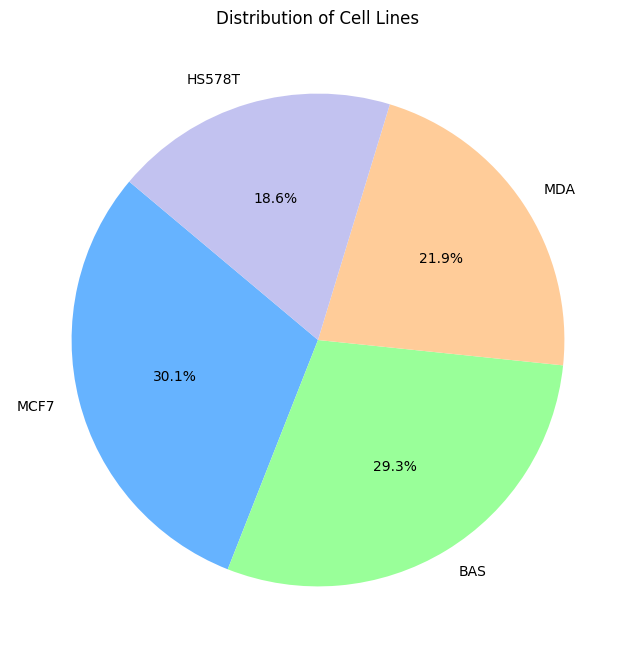

In [ ]:
#create a pie chart to visualize the distribution of target values
plt.figure(figsize=(8, 8))
plt.pie(target_count['Value Count'], labels=target_count[target_column], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Distribution of Cell Lines')
plt.show()

In [ ]:
#retrieve unique values in the Gene.symbol column of the DataFrame
df['Gene.symbol'].unique()

array(['EDIL3', 'IGFBP7', 'TFPI', ..., 'PLCB4',
       'SPANXA2///SPANXC///SPANXA1', 'SPANXB1'], dtype=object)

In [ ]:
#use OrdinalEncoder to encode categorical values in the Gene.symbol column
encoder = OrdinalEncoder()
df[['Gene.symbol']] = encoder.fit_transform(df[['Gene.symbol']])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21312 entries, 0 to 21311
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gene.symbol  21312 non-null  float64
 1   P.Value      21312 non-null  float64
 2   logFC        21312 non-null  float64
 3   Cell Line    21312 non-null  object 
dtypes: float64(3), object(1)
memory usage: 666.1+ KB


In [ ]:
#split the data into training and testing sets
X = df.drop([target_column] , axis=1)
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print("Samples in X_test:", len(X_test))
print("Samples in X_train:", len(X_train))

Samples in X_test: 6394
Samples in X_train: 14918


In [ ]:
#oversample 'HS578T' category
ros = RandomOverSampler(sampling_strategy={'HS578T': 4000}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
target_count_resampled = y_resampled.value_counts().reset_index().rename(columns={target_column: 'Value Count', 'index': target_column})

In [ ]:
#split the resampled dataset into training and test sets
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_resampled, y_resampled, random_state=42, test_size=0.3)

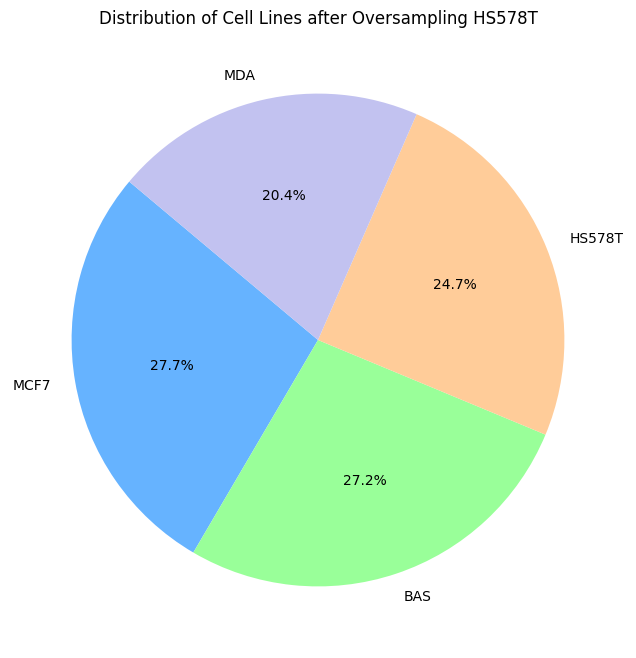

In [ ]:
#create a pie chart with resampled dataset distribution

plt.figure(figsize=(8, 8))
plt.pie(target_count_resampled['Value Count'], labels=target_count_resampled[target_column], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Distribution of Cell Lines after Oversampling HS578T')
plt.show()

In [ ]:
#Method 1: Simple AutoKeras
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
start1 = time.time()
autokeras_model = StructuredDataClassifier(max_trials=50)
autokeras_model.fit(X_train, y_train, validation_split=0.15, epochs=100, callbacks=[early_stopping])
autokeras_predictions = autokeras_model.predict(X_test)

print('Autokeras Prediction time:', round(time.time() - start1, 4))

Trial 50 Complete [00h 00m 36s]
val_accuracy: 0.6802167892456055

Best val_accuracy So Far: 0.7000903487205505
Total elapsed time: 01h 16m 34s
Epoch 1/100
467/467 [==============================] - 3s 4ms/step - loss: 1.2690 - accuracy: 0.4169
Epoch 2/100
467/467 [==============================] - 2s 4ms/step - loss: 1.1724 - accuracy: 0.4834
Epoch 3/100
467/467 [==============================] - 2s 4ms/step - loss: 1.1244 - accuracy: 0.5095
Epoch 4/100
467/467 [==============================] - 2s 4ms/step - loss: 1.0804 - accuracy: 0.5296
Epoch 5/100
467/467 [==============================] - 2s 5ms/step - loss: 1.0376 - accuracy: 0.5509
Epoch 6/100
467/467 [==============================] - 2s 4ms/step - loss: 0.9973 - accuracy: 0.5738
Epoch 7/100
467/467 [==============================] - 2s 4ms/step - loss: 0.9625 - accuracy: 0.5942
Epoch 8/100
467/467 [==============================] - 2s 4ms/step - loss: 0.9331 - accuracy: 0.6125
Epoch 9/100
467/467 [============================

In [ ]:
#Method 1: Simple AutoKeras (resampled)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
start1r = time.time()
autokeras_model = StructuredDataClassifier(max_trials=50)
autokeras_model.fit(X_trainr, y_trainr, validation_split=0.15, epochs=100, callbacks=[early_stopping])
autokeras_predictions_resampled = autokeras_model.predict(X_testr)

print('Autokeras Prediction time:', round(time.time() - start1r, 4))

Trial 50 Complete [00h 00m 24s]
val_accuracy: 0.6074380278587341

Best val_accuracy So Far: 0.671192467212677
Total elapsed time: 01h 01m 08s
Epoch 1/100
354/354 [==============================] - 2s 3ms/step - loss: 1.2829 - accuracy: 0.4075
Epoch 2/100
354/354 [==============================] - 1s 3ms/step - loss: 1.1916 - accuracy: 0.4629
Epoch 3/100
354/354 [==============================] - 1s 4ms/step - loss: 1.1431 - accuracy: 0.5055
Epoch 4/100
354/354 [==============================] - 1s 4ms/step - loss: 1.0967 - accuracy: 0.5394
Epoch 5/100
354/354 [==============================] - 1s 4ms/step - loss: 1.0507 - accuracy: 0.5628
Epoch 6/100
354/354 [==============================] - 1s 3ms/step - loss: 1.0086 - accuracy: 0.5812
Epoch 7/100
354/354 [==============================] - 1s 3ms/step - loss: 0.9760 - accuracy: 0.5950
Epoch 8/100
354/354 [==============================] - 1s 4ms/step - loss: 0.9518 - accuracy: 0.6038
Epoch 9/100
354/354 [=============================

In [ ]:
#calculate and print accuracy for Autokeras
accuracy_autokeras = accuracy_score(y_test, autokeras_predictions)
print('Autokeras Accuracy:', round(accuracy_autokeras, 4))

#calculate and print precision, recall, and f1 score for Autokeras
precision_autokeras = precision_score(y_test, autokeras_predictions, average='macro')
recall_autokeras = recall_score(y_test, autokeras_predictions,average='macro')
f1_autokeras = f1_score(y_test, autokeras_predictions, average='macro')

#print with three decimals
print('Precision:', round(precision_autokeras, 4))
print('Recall:', round(recall_autokeras, 4))
print('F1 Score:', round(f1_autokeras, 4))

Autokeras Accuracy: 0.6936
Precision: 0.7346
Recall: 0.6793
F1 Score: 0.6887


In [ ]:
#Resampled
#calculate and print accuracy for Autokeras
accuracy_autokeras = accuracy_score(y_testr, autokeras_predictions_resampled)
print('Autokeras Accuracy:', round(accuracy_autokeras, 4))

#calculate and print precision, recall, and f1 score for Autokeras
precision_autokeras = precision_score(y_testr, autokeras_predictions_resampled, average='macro')
recall_autokeras = recall_score(y_testr, autokeras_predictions_resampled,average='macro')
f1_autokeras = f1_score(y_testr, autokeras_predictions_resampled, average='macro')

#print with three decimals
print('Precision:', round(precision_autokeras, 4))
print('Recall:', round(recall_autokeras, 4))
print('F1 Score:', round(f1_autokeras, 4))

Autokeras Accuracy: 0.6945
Precision: 0.7482
Recall: 0.6902
F1 Score: 0.6986


Confusion Matrix (Autokeras):
 [[1615  122    7  110]
 [ 468  679   58   22]
 [ 386  197 1258  106]
 [ 424   53    6  883]]


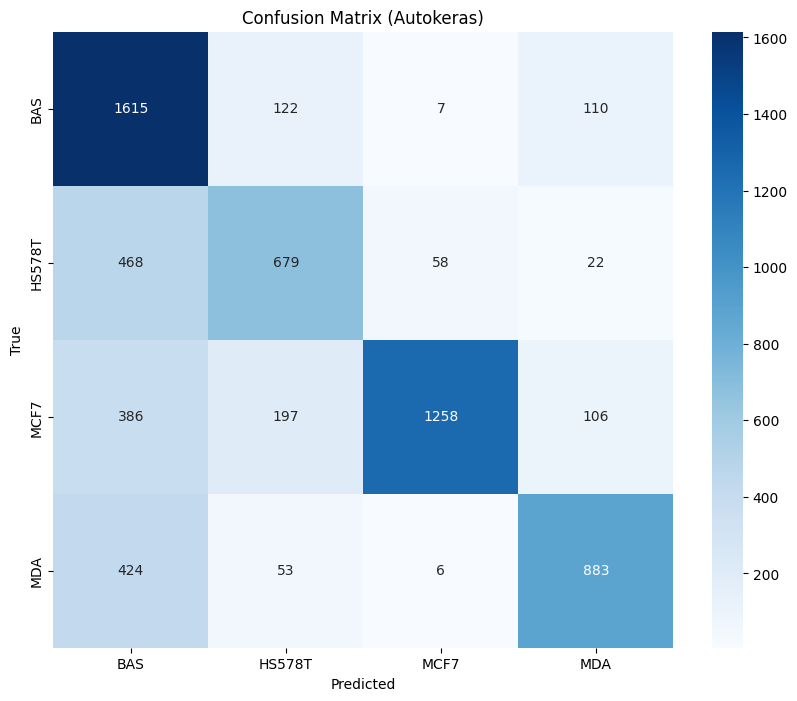

In [ ]:
#confusion matrix for AutoKeras
conf_matrix_autokeras = confusion_matrix(y_test, autokeras_predictions)
print('Confusion Matrix (Autokeras):\n', conf_matrix_autokeras)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_autokeras, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix (Autokeras)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion Matrix (Autokeras):
 [[1139   90    5   76]
 [ 453  652   63   18]
 [ 265  118  928   80]
 [ 297   18    0  653]]


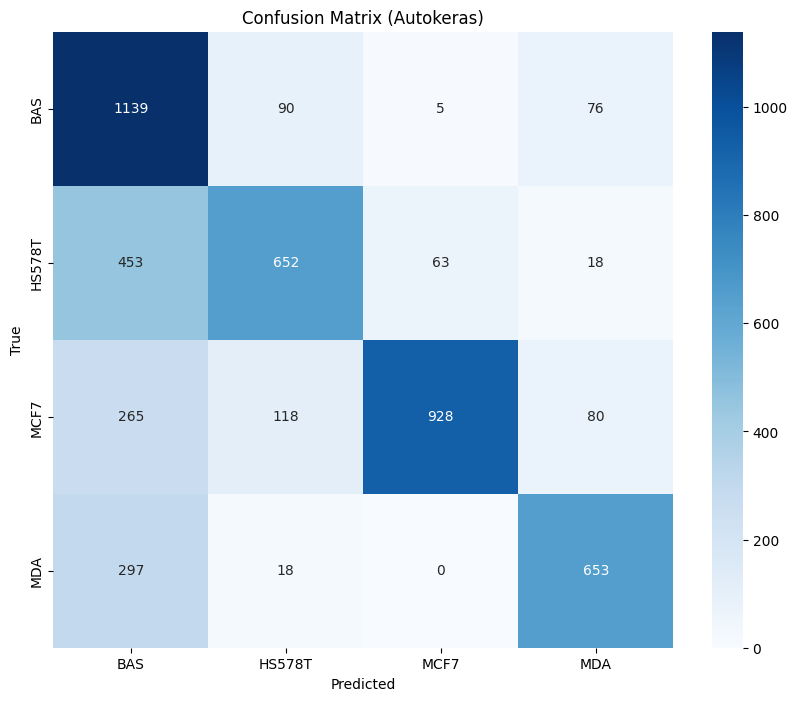

In [ ]:
#confusion matrix for AutoKeras with resampled data
conf_matrix_autokeras_r = confusion_matrix(y_testr, autokeras_predictions_resampled)
print('Confusion Matrix (Autokeras):\n', conf_matrix_autokeras_r)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_autokeras_r, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_testr)), yticklabels=sorted(set(y_testr)))
plt.title('Confusion Matrix (Autokeras)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#create subset with 1000 records for the TabPFN classifier
subset_df = df.sample(n=1000, random_state=42)
subset_count = val_count_df(subset_df, target_column)
display(subset_count)

#split dataset into traing and test subsets
X2 = subset_df.drop([target_column] , axis=1)
y2 = subset_df[target_column]
X_trainV2, X_testV2, y_trainV2, y_testV2 = train_test_split(X2, y2, random_state=42, test_size=0.3)

#print samples in training and test sets
print("Samples in X_test:", len(X_testV2))
print("Samples in X_train:", len(X_trainV2))

,Cell Line,Value Count
0,MCF7,299
1,BAS,298
2,MDA,216
3,HS578T,187


Samples in X_test: 300
Samples in X_train: 700


In [ ]:
#oversample 'HS578T'
ros_subset = RandomOverSampler(sampling_strategy={'HS578T': 230}, random_state=42)
X2_resampled_hs578t, y2_resampled_hs578t = ros_subset.fit_resample(X2, y2)

#undersample 'MCF7', 'BAS'
rus_subset = RandomUnderSampler(sampling_strategy={'MCF7': 277, 'BAS': 277}, random_state=42)
X2_resampled_subset, y2_resampled_subset = rus_subset.fit_resample(X2_resampled_hs578t, y2_resampled_hs578t)

In [ ]:
#split the resampled dataset into training and test sets
X_trainV2r, X_testV2r, y_trainV2r, y_testV2r = train_test_split(X2_resampled_subset, y2_resampled_subset, random_state=42, test_size=0.3)

In [ ]:
#print number of samples per subset
print("Samples in X_test after oversampling and undersampling:", len(X_testV2r))
print("Samples in X_train after oversampling and undersampling:", len(X_trainV2r))

Samples in X_test after oversampling and undersampling: 300
Samples in X_train after oversampling and undersampling: 700


In [ ]:
# Method 2: TabPFN Pipeline
start2 = time.time()
classifier = TabPFNClassifier()
classifier.fit(X_trainV2, y_trainV2, overwrite_warning=False)
y_evalV2 = classifier.predict(X_testV2)

print('Prediction time: ', time.time() - start2, 'Accuracy', round(accuracy_score(y_testV2, y_evalV2), 4))

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Prediction time:  8.544447898864746 Accuracy 0.6467


In [ ]:
# Method 2: TabPFN Pipeline (resampled)
start2r = time.time()
classifier = TabPFNClassifier()
classifier.fit(X_trainV2r, y_trainV2r, overwrite_warning=False)
y_evalV2r = classifier.predict(X_testV2r)

print('Prediction time: ', time.time() - start2r, 'Accuracy', round(accuracy_score(y_testV2r, y_evalV2r), 4))

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Prediction time:  9.149168252944946 Accuracy 0.62


In [ ]:
#metrics for TabPFN method
precision = precision_score(y_testV2, y_evalV2, average='macro')
recall = recall_score(y_testV2, y_evalV2, average='macro')
f1 = f1_score(y_testV2, y_evalV2, average='macro')

print('The TabPFN model Precision is:', round(precision, 4))
print('The TabPFN model Recall is:', round(recall, 4))
print('The TabPFN model F1 Score is:', round(f1, 4))

The TabPFN model Precision is: 0.6741
The TabPFN model Recall is: 0.624
The TabPFN model F1 Score is: 0.6197


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#metrics for TabPFN method with resampled data
precisionr = precision_score(y_testV2r, y_evalV2r, average='macro')
recallr = recall_score(y_testV2r, y_evalV2r, average='macro')
f1r = f1_score(y_testV2r, y_evalV2r, average='macro')

print('The TabPFN model Precision is:', round(precisionr, 4))
print('The TabPFN model Recall is:', round(recallr, 4))
print('The TabPFN model F1 Score is:', round(f1r, 4))

The TabPFN model Precision is: 0.6423
The TabPFN model Recall is: 0.6168
The TabPFN model F1 Score is: 0.6226


Confusion Matrix (TabPFN):
 [[72  3 12  8]
 [22 16 21  3]
 [15  3 60  2]
 [16  1  0 46]]


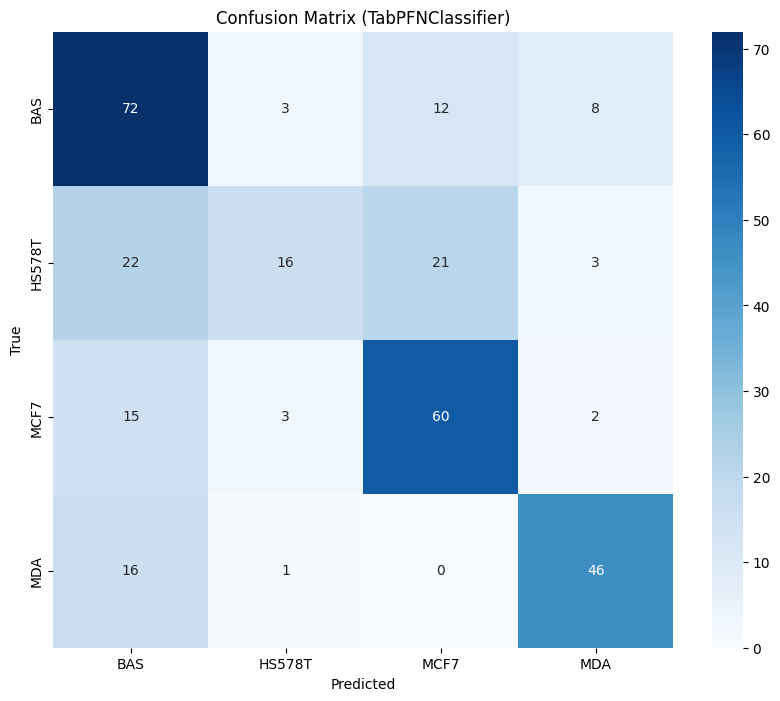

In [ ]:
#confusion matrix for TabPFN method
conf_matrix_tabpfn = confusion_matrix(y_testV2, y_evalV2)
print('Confusion Matrix (TabPFN):\n', conf_matrix_tabpfn)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tabpfn, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_testV2)), yticklabels=sorted(set(y_testV2)))
plt.title('Confusion Matrix (TabPFNClassifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion Matrix (TabPFN Resampled):
 [[51 12  8 10]
 [22 33 13  2]
 [15  5 56  3]
 [19  1  4 46]]


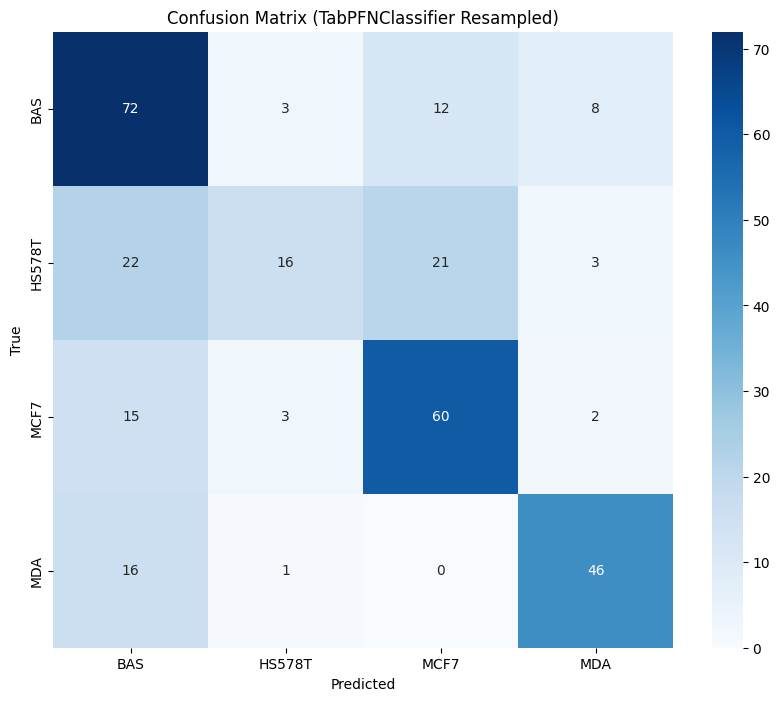

In [ ]:
#confusion matrix for TabPFN method with resampled data
conf_matrix_tabpfn_r = confusion_matrix(y_testV2r, y_evalV2r)
print('Confusion Matrix (TabPFN Resampled):\n', conf_matrix_tabpfn_r)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tabpfn, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(y_testV2r)), yticklabels=sorted(set(y_testV2r)))
plt.title('Confusion Matrix (TabPFNClassifier Resampled)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()